In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep


Using TensorFlow backend.


In [2]:
#Tissue types to compile data for

tissue_types = [
    'Adipose_Subcutaneous',
    'Adipose_Visceral_Omentum',
    'Adrenal_Gland',
    'Artery_Aorta',
    'Artery_Coronary',
    'Artery_Tibial',
    'Brain_Amygdala',
    'Brain_Anterior_cingulate_cortex_BA24',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    #'Brain_Cerebellum',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
    'Brain_Hippocampus',
    'Brain_Hypothalamus',
    'Brain_Nucleus_accumbens_basal_ganglia',
    'Brain_Putamen_basal_ganglia',
    'Brain_Spinal_cord_cervical_c-1',
    'Brain_Substantia_nigra',
    'Breast_Mammary_Tissue',
    'Cells_EBV-transformed_lymphocytes',
    'Cells_Cultured_fibroblasts',
    'Colon_Sigmoid',
    'Colon_Transverse',
    'Esophagus_Gastroesophageal_Junction',
    'Esophagus_Mucosa',
    'Esophagus_Muscularis',
    'Heart_Atrial_Appendage',
    'Heart_Left_Ventricle',
    'Kidney_Cortex',
    'Liver',
    'Lung',
    'Minor_Salivary_Gland',
    'Muscle_Skeletal',
    'Nerve_Tibial',
    'Ovary',
    'Pancreas',
    'Pituitary',
    'Prostate',
    'Skin_Not_Sun_Exposed_Suprapubic',
    'Skin_Sun_Exposed_Lower_leg',
    'Small_Intestine_Terminal_Ileum',
    'Spleen',
    'Stomach',
    'Testis',
    'Thyroid',
    'Uterus',
    'Vagina',
    'Whole_Blood'
]


In [3]:
len(tissue_types)

48

In [4]:

version_suffix = '_v8'


median spearman r = 0.44, n = 8381.0
median p-value = 1e-06, n = 8381.0
median dir AP = 0.76
median sig AP = 0.56


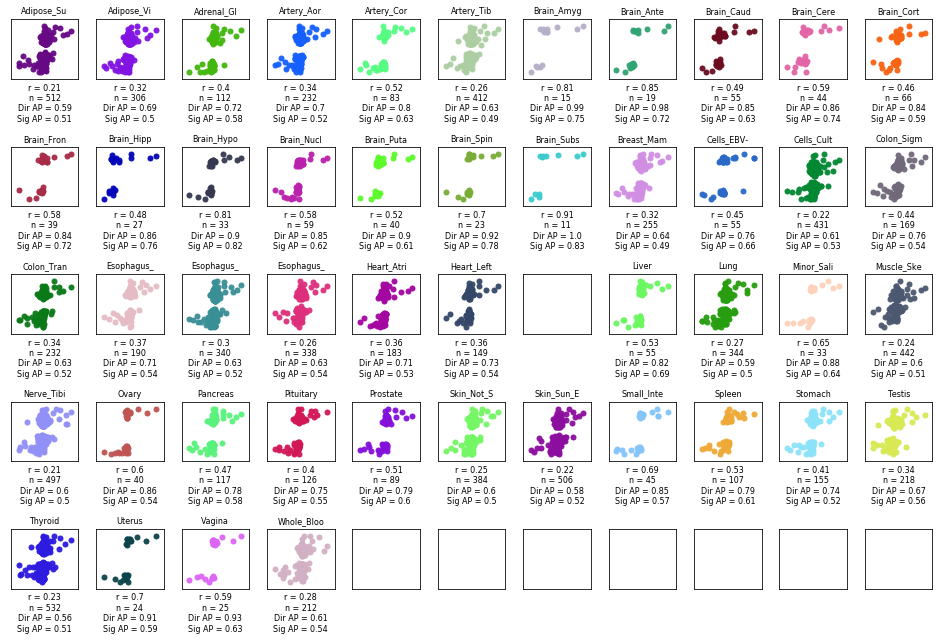

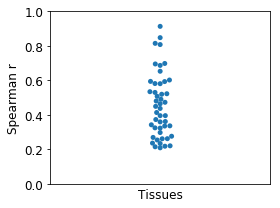

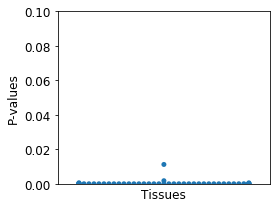

In [9]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

save_figs = False

n_rows = 5
n_cols = 11

f, axs = plt.subplots(n_rows, n_cols, figsize=(1.2 * n_cols, 1.8 * n_rows))

spearman_r_vals = []
spearman_p_vals = []
ns = []

dir_ap_vals = []
sig_ap_vals = []

total_n = 0.

source_df = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_v8_nonlead_predictions_pred_df.csv", sep='\t')

for i, tissue_type in enumerate(tissue_types) :
    
    snp_pred_df = source_df.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
    
    snp_pred_df = snp_pred_df.query("p_val < 1e-20").copy().reset_index(drop=True)
    
    def _determine_cis_snp(row) :
        
        if row['snp_distance'] < 150 :
            return 1.
        elif row['snp_distance'] < 500 and (row['pas'] == -1 or row['pas'] >= 2) and (row['wide_seq_ext'][175:175+6] != row['wide_seq_ext_var'][175:175+6]) :
            return 1.
        else :
            return -1.
    
    snp_pred_df['cis_snp'] = snp_pred_df.apply(_determine_cis_snp, axis=1)
    
    snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105
    
    #PDUI
    snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']))
    snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']
    
    snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']

    snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])
    
    lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)
    
    lead_snp_pred_df['cut_to_snp'] = np.abs(lead_snp_pred_df['snp_pos'] - 100)
    
    lead_snp_pred_df = lead_snp_pred_df.sort_values(by='p_val', ascending=True).drop_duplicates(subset=['snp_id', 'gene_id'], keep='first')
    lead_snp_pred_df = lead_snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')
    
    lead_snp_pred_df = lead_snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)
    
    lead_snp_pred_df['mutated_pas'] = lead_snp_pred_df['wide_seq_ext'].str.slice(175, 175+6) != lead_snp_pred_df['wide_seq_ext_var'].str.slice(175, 175+6)
    
    lead_snp_pred_df_backup = lead_snp_pred_df
    
    filtered_df = lead_snp_pred_df.query("snp_pos >= 20 and snp_pos < 126 and pas != -1")
    
    #Remove SNPs which destroy a canonical PAS far away from distal site but with negative effect sizes (clearly incorrect sign)
    filtered_df = filtered_df.query("not (snp_distance >= 250 and snp_distance < 1000 and pas <= 1 and mutated_pas == True and effect_size < 0.0)")
    
    row = i // n_cols
    col = i % n_cols
    
    y_pred = np.ravel(np.array(filtered_df['effect_size_pred'].values))
    y_true = np.ravel(np.array(filtered_df['effect_size'].values))

    spearman_r_val, spearman_p_val = spearmanr(y_pred, y_true)
    
    y_labels = np.array(filtered_df['effect_size'].apply(lambda x: 0 if x < 0. else 1).values)
    y_score = np.array(filtered_df['effect_size_pred'].values)
    
    dir_average_precision = average_precision_score(y_labels, y_score) if np.unique(y_labels).shape[0] > 1 else 0.

    q_val = np.quantile(np.abs(filtered_df['effect_size'].values), q=0.5) if len(filtered_df) > 1 else 0.

    y_labels = np.array(filtered_df['effect_size'].apply(lambda x: 0 if np.abs(x) < q_val else 1).values)
    y_score = np.array(filtered_df['effect_size_pred'].values)

    sig_average_precision = average_precision_score(y_labels, y_score) if np.unique(y_labels).shape[0] > 1 else 0.

    if i < 49 and len(filtered_df) > 1 :
        
        rgb = (random.random(), random.random(), random.random())
        
        axs[row, col].scatter(y_pred, y_true, alpha=0.95, s=25, color=rgb)
        axs[row, col].set_title(tissue_type[:10], fontsize=8)
        axs[row, col].set_xlabel("r = " + str(round(spearman_r_val, 2)) + "\nn = " + str(int(len(filtered_df))) + "\nDir AP = " + str(round(dir_average_precision, 2)) + "\nSig AP = " + str(round(sig_average_precision, 2)), fontsize=8)
        
        x_width = np.max(y_pred) - np.min(y_pred)
        y_width = np.max(y_true) - np.min(y_true)
        
        if x_width > 0 and y_width > 0 :
            axs[row, col].set_xlim(
                np.min(y_pred) - 0.15 * x_width,
                np.max(y_pred) + 0.15 * x_width
            )

            axs[row, col].set_ylim(
                np.min(y_true) - 0.15 * y_width,
                np.max(y_true) + 0.15 * y_width
            )
    
    if not np.isnan(spearman_r_val) :
        spearman_r_vals.append(spearman_r_val)
        spearman_p_vals.append(spearman_p_val)
        ns.append(int(len(filtered_df)))
        
        dir_ap_vals.append(dir_average_precision)
        sig_ap_vals.append(sig_average_precision)
    
    total_n += y_pred.shape[0]

for row in range(n_rows) :
    
    for col in range(n_cols) :

        axs[row, col].set_xticks([], [])
        axs[row, col].set_yticks([], [])

plt.tight_layout()

print('median spearman r = ' + str(round(np.median(spearman_r_vals), 2)) + ', n = ' + str(total_n))
print('median p-value = ' + str(round(np.median(spearman_p_vals), 6)) + ', n = ' + str(total_n))

print('median dir AP = ' + str(round(np.median(dir_ap_vals), 2)))
print('median sig AP = ' + str(round(np.median(sig_ap_vals), 2)))

if save_figs :
    plt.savefig('gtex_apaqtl_v8_pred_aparent_resnet_multi' + version_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('gtex_apaqtl_v8_pred_aparent_resnet_multi' + version_suffix + '.eps')

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_r_vals)])

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 1.0)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_v8_pred_aparent_resnet_r_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_v8_pred_aparent_resnet_r_value_swarm" + version_suffix + ".eps")

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_p_vals)])

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 0.1)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("P-values", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_v8_pred_aparent_resnet_p_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_v8_pred_aparent_resnet_p_value_swarm" + version_suffix + ".eps")

plt.show()
